In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input


# Cruide Oil WTI

## 7:3

In [13]:
# Đọc dữ liệu
df = pd.read_csv('../dataset/Crude Oil.csv')

In [14]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])

In [15]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-03-27,80.92,81.28,81.31,80.89,NaN,-0.44%
1,2024-03-26,81.28,82.05,82.34,81.17,NaN,-0.82%
2,2024-03-25,81.95,80.85,82.48,80.59,300.36K,1.64%
3,2024-03-22,80.63,80.84,81.45,80.42,231.10K,-0.54%
4,2024-03-21,81.07,81.49,81.92,80.30,266.86K,-0.75%
...,...,...,...,...,...,...,...
1380,2019-01-07,48.52,48.30,49.79,48.11,819.94K,1.17%
1381,2019-01-04,47.96,46.90,49.22,46.65,817.28K,1.85%
1382,2019-01-03,47.09,46.26,47.49,45.35,788.72K,1.18%
1383,2019-01-02,46.54,45.80,47.78,44.35,850.48K,1.42%


In [16]:

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Đảo ngược dữ liệu để dự đoán giá trị trong tương lai
df = df.iloc[::-1].reset_index(drop=True)

In [17]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-01-02,46.54,45.80,47.78,44.35,850480.0,1.42
1,2019-01-03,47.09,46.26,47.49,45.35,788720.0,1.18
2,2019-01-04,47.96,46.90,49.22,46.65,817280.0,1.85
3,2019-01-07,48.52,48.30,49.79,48.11,819940.0,1.17
4,2019-01-08,49.78,48.73,49.95,48.31,765980.0,2.60
...,...,...,...,...,...,...,...
1289,2024-03-19,83.47,82.85,83.85,82.39,76810.0,0.91
1290,2024-03-20,81.68,83.20,83.21,81.44,26040.0,-2.14
1291,2024-03-21,81.07,81.49,81.92,80.30,266860.0,-0.75
1292,2024-03-22,80.63,80.84,81.45,80.42,231100.0,-0.54


In [18]:
price = df['Price'].values
price = price.reshape(-1, 1)

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [20]:
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [21]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20

X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [22]:
# Xây dựng mô hình RNN
model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
# 11. Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1341
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0136
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.1268e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4531e-04
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.9854e-04
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.8791e-04
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0653e-04
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.8622e-04
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.5663e-04
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.0303e-04
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.3806e-04
Epoch 15/100
14/14 ━━

In [24]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [25]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 2.0388734337797025
MAPE trên tập test là: 2.123523271070402 %
MAE trên tập test là: 1.6651499117975648


In [26]:
last_30_days = price_scaled[-look_back:]
next_30_days = []

for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat[0, 0])
    last_30_days = np.append(last_30_days, y_hat)[-look_back:]

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [27]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1294,80.991028
1295,80.547638
1296,80.150414
1297,79.917679
1298,79.724579
1299,79.378334
1300,79.355667
1301,79.373711
1302,79.132050
1303,78.869118


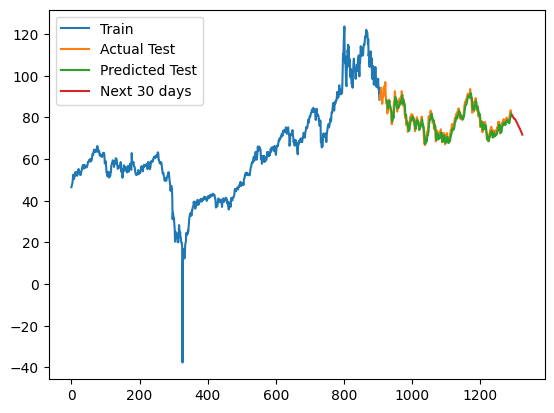

In [28]:
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.savefig('RNN_Cruide_Oil_73.png') 
plt.show()


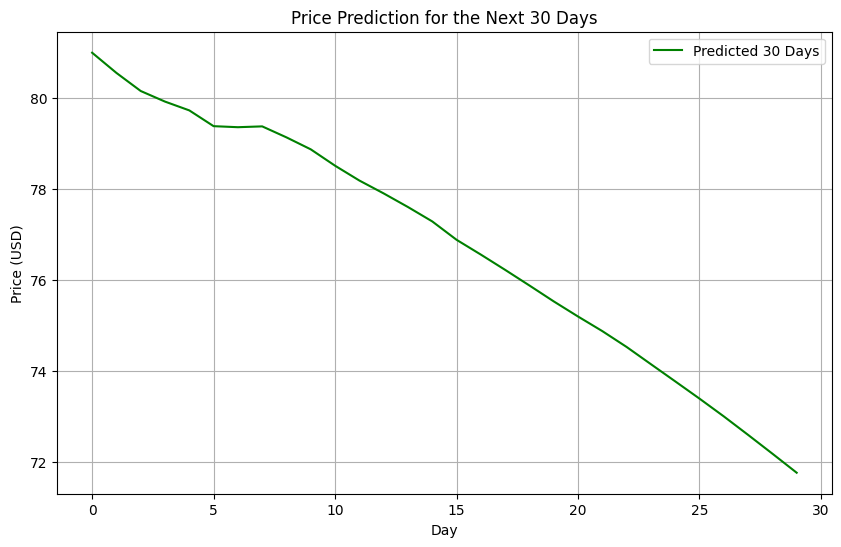

In [29]:
plt.figure(figsize=(10, 6))
predict_30_days_index = pd.RangeIndex(start=0, stop=30, step=1)
plt.plot(predict_30_days_index, next_30_days, label='Predicted 30 Days', color='green')
plt.title('Price Prediction for the Next 30 Days')
plt.xlabel('Day')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## 8:2

In [30]:
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [31]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20

X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [32]:
# Xây dựng mô hình RNN
model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1620
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0144
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.7391e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.0668e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.2022e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.2556e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7424e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8793e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.0521e-04
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.0338e-04
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.0732e-04
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7919e-04
Epoch 15/100
16/16

In [34]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [35]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 2.9902195952908444
MAPE trên tập test là: 3.3927442748146084 %
MAE trên tập test là: 2.6313751695136034


In [36]:
last_30_days = price_scaled[-look_back:]
next_30_days = []

for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat[0, 0])
    last_30_days = np.append(last_30_days, y_hat)[-look_back:]

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [37]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1294,79.067909
1295,77.613022
1296,76.147369
1297,74.872055
1298,73.493805
1299,72.191284
1300,71.020302
1301,69.738075
1302,68.220581
1303,66.850967


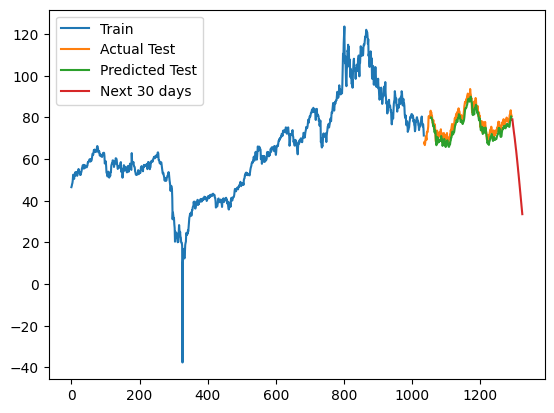

In [38]:
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.savefig('RNN_Cruide_Oil_82.png') 
plt.show()


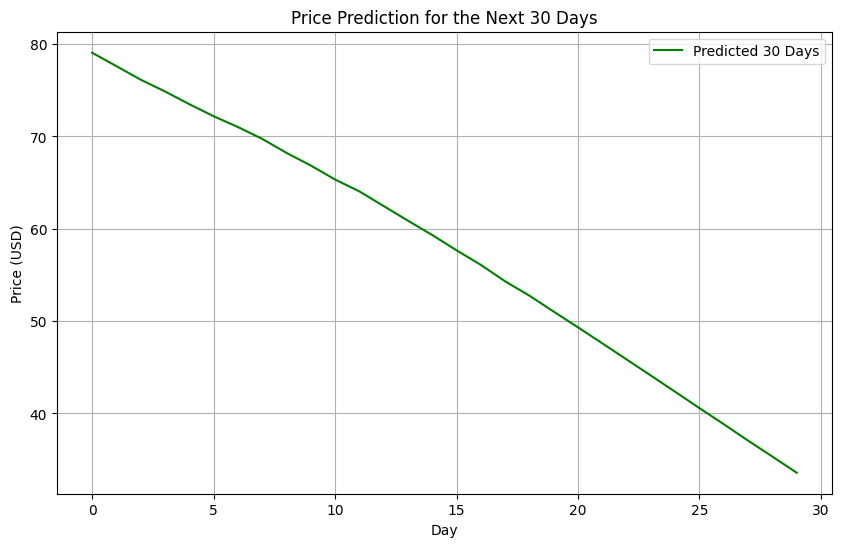

In [39]:
plt.figure(figsize=(10, 6))
predict_30_days_index = pd.RangeIndex(start=0, stop=30, step=1)
plt.plot(predict_30_days_index, next_30_days, label='Predicted 30 Days', color='green')
plt.title('Price Prediction for the Next 30 Days')
plt.xlabel('Day')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### 9:1

In [40]:
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled) * 0.1)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [41]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20

X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [42]:
# Xây dựng mô hình RNN
model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [43]:
# 11. Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.3363
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0206
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3030e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4454e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0814e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5083e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2425e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4827e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2865e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7231e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.9621e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4710e-04
Epoch 15/100
18/18 ━

In [44]:
# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform([Y_test])

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


In [45]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0]) * 100
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 2.4215846429371606
MAPE trên tập test là: 2.7229018741813253 %
MAE trên tập test là: 2.097112961515372


In [46]:
last_30_days = price_scaled[-look_back:]
next_30_days = []

for i in range(30):
    x = last_30_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat[0, 0])
    last_30_days = np.append(last_30_days, y_hat)[-look_back:]

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

print(next_30_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [47]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(df), len(df)+len(next_30_days))
next_30_days_df.index = next_30_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_30_days_df

,0
1294,79.539124
1295,78.771301
1296,77.769913
1297,76.747093
1298,75.995720
1299,74.997398
1300,73.986122
1301,73.089394
1302,72.258080
1303,71.185104


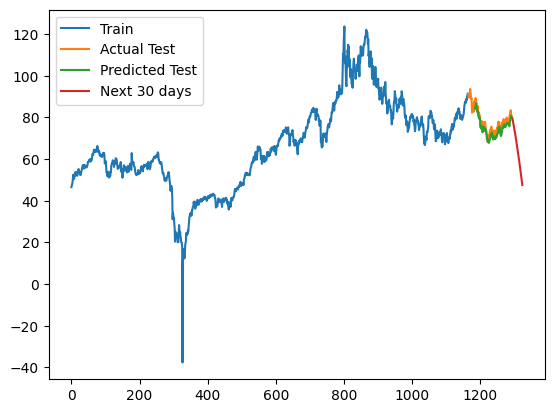

In [48]:
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')

plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.savefig('RNN_Cruide_Oil_91.png') 
plt.show()

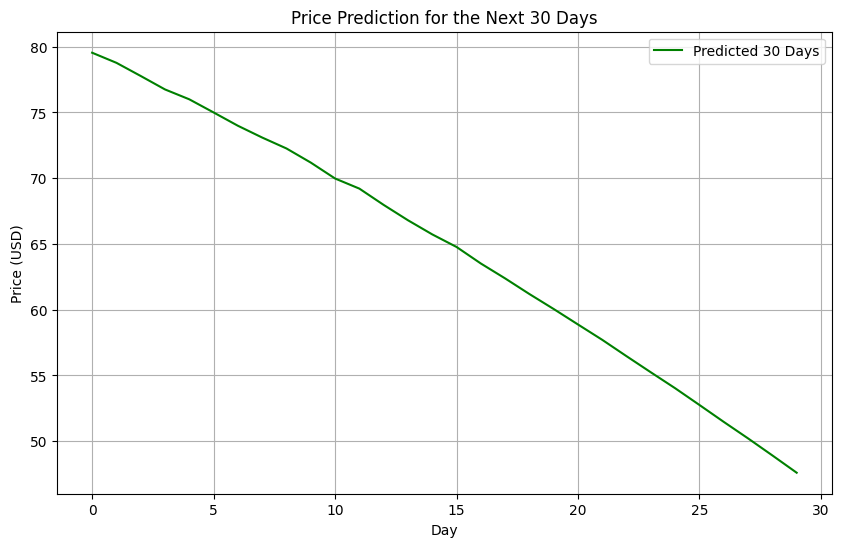

In [49]:
plt.figure(figsize=(10, 6))
predict_30_days_index = pd.RangeIndex(start=0, stop=30, step=1)
plt.plot(predict_30_days_index, next_30_days, label='Predicted 30 Days', color='green')
plt.title('Price Prediction for the Next 30 Days')
plt.xlabel('Day')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()